# MDP with Unmeasured Confounders

The model we are using:  
Medical Treatment model as defined in Appendix A in https://causalai.net/mdp-causal.pdf

In [80]:
def physicains_policy(St, Mt, Et):
    return (St+Mt+Et) % 2

In [81]:
import numpy as np
# probability_yt_is_1 is a 4 dimensional array
# format: probability_yt_is_1[St][Mt][Et][Xt] is P(Yt = 1 | Xt, St, Mt, Et)
probability_yt_is_1 = np.zeros((2,2,2,2))
probability_yt_is_1[0][0][0][0] = 0.2
probability_yt_is_1[0][0][0][1] = 0.9
probability_yt_is_1[0][0][1][0] = 0.9
probability_yt_is_1[0][0][1][1] = 0.2
probability_yt_is_1[0][1][0][0] = 0.8
probability_yt_is_1[0][1][0][1] = 0.3
probability_yt_is_1[0][1][1][0] = 0.3
probability_yt_is_1[0][1][1][1] = 0.8

probability_yt_is_1[1][0][0][0] = 0.7
probability_yt_is_1[1][0][0][1] = 0.2
probability_yt_is_1[1][0][1][0] = 0.2
probability_yt_is_1[1][0][1][1] = 0.7
probability_yt_is_1[1][1][0][0] = 0.1
probability_yt_is_1[1][1][0][1] = 0.8
probability_yt_is_1[1][1][1][0] = 0.8
probability_yt_is_1[1][1][1][1] = 0.1

In [82]:
# transition_prob is a 2 dimensional array
# format: transition_prob[Xt][St] = P(St+1 = 0 | St, Xt)
transition_prob = np.zeros((2,2))
transition_prob[0][0] = 0.9
transition_prob[0][1] = 0.3
transition_prob[1][0] = 0.7
transition_prob[1][1] = 0.8

In [83]:
def get_Yt(St, Mt, Et, Xt):
    u = np.random.rand()
    if u < probability_yt_is_1[St][Mt][Et][Xt]:
        return 1
    return 0

In [84]:
def get_next_state(St, Xt):
    u = np.random.rand()
    if u < transition_prob[Xt][St]:
        return 0
    return 1

# Generate data from our model

In [85]:
import pandas as pd

data_df = pd.DataFrame()

In [86]:
def generate_single_trajectory(patient_id):
    global data_df
    St = np.random.randint(2)
    for t in range(100):
        Mt, Et = np.random.randint(2), np.random.randint(2)
        Xt = physicains_policy(St, Mt, Et)
        Yt = get_Yt(St, Mt, Et, Xt)
        data_df = data_df.append({'pt_id': patient_id,'t': t, 'St': St, 'Mt': Mt, 'Et': Et, 'Xt': Xt, 'Yt': Yt}, ignore_index=True)
        St = get_next_state(St, Xt)

In [92]:
for patient_id in range(18242):
    if patient_id % 1000 == 0:
        print("Iteration number: ", patient_id)
    generate_single_trajectory(patient_id)

In [94]:
data_df.to_csv('/Users/faaiz/MDPUC/data.csv')

In [95]:
data_df.head()

,Et,Mt,St,Xt,Yt,pt_id,t
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,2.0
3,1.0,0.0,0.0,1.0,1.0,0.0,3.0
4,1.0,0.0,0.0,1.0,0.0,0.0,4.0


In [294]:
############## Define parameters #################

n_states = 2
n_actions = 2

### Divide the data into training and testing sets

In [109]:
patients = data_df['pt_id'].unique()
training = patients[np.random.randint(5, size = (len(patients))) != 4]
testing = patients[np.random.randint(5, size = (len(patients))) == 4]

train_data = data_df.loc[data_df['pt_id'].isin(training)].reset_index()
test_data = data_df.loc[data_df['pt_id'].isin(testing)].reset_index()

# Finding optimal policy assuming the confounders $E_{t}$ and $M_{t}$ are not measured
The states of MDP are $S_t$, actions are $X_t$ and rewards are $Y_t$
### 1. Estimating the Transition matrix T(S,S',A) and Reward matrix R(S,A)

In [116]:
transition = np.zeros((n_states,n_states,n_actions))
sums = np.zeros((n_states,n_actions))
R = np.zeros((n_states,n_actions))

for index, row in train_data.iterrows():
    if index < len(train_data)-1 and train_data.at[index + 1, 't'] != 0:
        S0, S1, action, Y = int(train_data.at[index, 'St']), int(train_data.at[index+1, 'St']), int(train_data.at[index, 'Xt']), int(train_data.at[index, 'Yt'])
        transition[S0][S1][action] += 1
        R[S0][action] += Y
        sums[S0][action] += 1
        
for i in range(n_states):
    for j in range(n_actions):
        if sums[i][j] != 0:
            R[i][j] = R[i][j]/sums[i][j]
            for k in range(n_states):
                transition[i][k][j] = transition[i][k][j]/sums[i][j]

Sanity Check to make sure transition matrix estimate is accurate

In [115]:
transition

array([[[0.89987782, 0.70066325],
        [0.10012218, 0.29933675]],

       [[0.29994861, 0.80034186],
        [0.70005139, 0.19965814]]])

Estimate physician's policy from data

In [172]:
physpol = (sums.T/((sums.sum(axis=1)==0) + (sums.sum(axis=1)))).T

### 2. Do policy iteration

In [295]:
from mdp_utils import *

gamma = 0.99
_, _, i, Qon = mdp_policy_iteration_with_Q(transition, R, gamma, np.ones(n_states))
OptimalAction = Qon.argmax(axis=1) # deterministic

In [296]:
Qon

array([[23.8969691 , 23.87507313],
       [23.73126535, 23.78559731]])

### 3. Off policy evaluation on Test dataset

In [178]:
# behaviour policy is the physician's policy
p = 0.01
softpi = physpol.copy()
for i in range(n_states):
    zeros = softpi[i]==0
    if zeros.sum() > 0 and (~zeros).sum() > 0:
            z = p/zeros.sum()
            softpi[i][zeros] = z
            nz = p/(~zeros).sum()
            softpi[i][~zeros] = softpi[i][~zeros] - nz

In [180]:
# evaluation policy is epsilon greedy version of OptimalAction
softb = np.zeros((n_states, n_actions)) + p/(n_actions-1)
for i in range(n_states):
    softb[i][OptimalAction[i]] = 1-p

In [182]:
OPevaluation_data = test_data.copy()
for index, row in OPevaluation_data.iterrows():
    OPevaluation_data.at[index, 'softpi(s,a)'] = softpi[int(row['St'])][int(row['Xt'])]
    OPevaluation_data.at[index, 'softb(s,a)'] = softb[int(row['St'])][int(row['Xt'])]
    OPevaluation_data.at[index, 'optimal_action'] = OptimalAction[int(row['St'])]

In [190]:
OPevaluation_data.head()

,index,Et,Mt,St,Xt,Yt,pt_id,t,"softpi(s,a)","softb(s,a)",optimal_action
0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.499634,0.01,0.0
1,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.499634,0.01,0.0
2,2,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.499634,0.01,0.0
3,3,1.0,0.0,0.0,1.0,1.0,0.0,3.0,0.499634,0.01,0.0
4,4,1.0,0.0,0.0,1.0,0.0,0.0,4.0,0.499634,0.01,0.0


In [297]:
from offpolicy_eval import *

bootwis = offpolicy_eval_wis(OPevaluation_data,0.99,750)

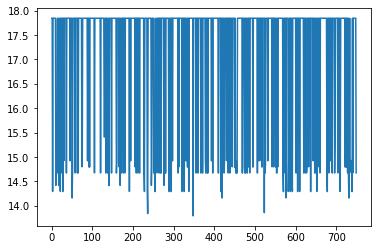

In [299]:
import matplotlib.pyplot as plt

plt.plot(bootwis)
plt.show()

# Calculating Actual value of the policy in a model with all confounders

We define a state variable $S'_t$ which contains information about all confounders

In [238]:
complete_model_test = test_data.copy()

In [239]:
complete_model_test['St'] = complete_model_test['Et'] + 2*complete_model_test['Mt'] + 4*complete_model_test['St']
complete_model_test.drop(columns=['Et', 'Mt'], inplace=True)
complete_model_test.head()

,index,St,Xt,Yt,pt_id,t
0,0,1.0,1.0,0.0,0.0,0.0
1,1,2.0,1.0,0.0,0.0,1.0
2,2,2.0,1.0,1.0,0.0,2.0
3,3,1.0,1.0,1.0,0.0,3.0
4,4,1.0,1.0,0.0,0.0,4.0


In [240]:
def mapDeterministicPolicyToNewStateSpace(policy):
    mapped_policy = np.zeros(8)
    for i in range(4):
        mapped_policy[i] = policy[0]
    for i in range(4,8):
        mapped_policy[i] = policy[1]
    return mapped_policy

In [241]:
newOptimalPolicy = mapDeterministicPolicyToNewStateSpace(OptimalAction)

In [242]:
n_states = 8
n_actions = 2
sums = np.zeros((n_states,n_actions))
for index, row in complete_model_test.iterrows():
    S0, action = int(complete_model_test.at[index, 'St']), int(complete_model_test.at[index, 'Xt'])
    sums[S0][action] += 1

In [243]:
physpol = (sums.T/((sums.sum(axis=1)==0) + (sums.sum(axis=1)))).T

In [245]:
# behaviour policy is the physician's policy
p = 0.01
softpi = physpol.copy()
for i in range(n_states):
    zeros = softpi[i]==0
    if zeros.sum() > 0 and (~zeros).sum() > 0:
            z = p/zeros.sum()
            softpi[i][zeros] = z
            nz = p/(~zeros).sum()
            softpi[i][~zeros] = softpi[i][~zeros] - nz

In [249]:
# evaluation policy is epsilon greedy version of OptimalAction
softb = np.zeros((n_states, n_actions)) + p/(n_actions-1)
for i in range(n_states):
    softb[i][int(newOptimalPolicy[i])] = 1-p

In [251]:
for index, row in complete_model_test.iterrows():
    complete_model_test.at[index, 'softpi(s,a)'] = softpi[int(row['St'])][int(row['Xt'])]
    complete_model_test.at[index, 'softb(s,a)'] = softb[int(row['St'])][int(row['Xt'])]
    complete_model_test.at[index, 'optimal_action'] = newOptimalPolicy[int(row['St'])]

In [252]:
complete_model_test.head()

,index,St,Xt,Yt,pt_id,t,"softpi(s,a)","softb(s,a)",optimal_action
0,0,1.0,1.0,0.0,0.0,0.0,0.99,0.01,0.0
1,1,2.0,1.0,0.0,0.0,1.0,0.99,0.01,0.0
2,2,2.0,1.0,1.0,0.0,2.0,0.99,0.01,0.0
3,3,1.0,1.0,1.0,0.0,3.0,0.99,0.01,0.0
4,4,1.0,1.0,0.0,0.0,4.0,0.99,0.01,0.0


In [253]:
bootwis_actual = offpolicy_eval_wis(complete_model_test,0.99,750)

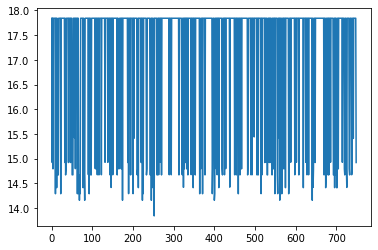

In [264]:
plt.plot(bootwis_actual)
plt.show()

In [265]:
bootwis_actual.mean()

17.093170811295916

In [266]:
bootwis.mean()

17.066969832734127